<a href="https://colab.research.google.com/github/evtaktasheva/hse-NNmethods/blob/main/NNMethods_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet torchmetrics
!pip install --quiet pymorphy2[fast]

     |████████████████████████████████| 329 kB 5.5 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 8.2 MB 10.7 MB/s 
     |████████████████████████████████| 371 kB 47.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from collections import Counter
tqdm.pandas()
from string import punctuation
from nltk import TweetTokenizer
from pymorphy2 import MorphAnalyzer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1

from sklearn.metrics import f1_score


In [3]:
def set_seed(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## 0. Данные:

In [4]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2021-11-25 10:47:00--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-11-25 10:47:00--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc43bf807df0c42b9e45b08cce39.dl.dropboxusercontent.com/cd/0/inline/Bao1j-06InjYQXCAbgGjhtWqcU87iJBNMvxRY30H3hIac3GGJ2lokN30VcHI-oJZvzYv6CvRj4m2K2qGhxqNKMatP7ayUdGGnP7IqCLnIWHmMUOiob8NekwHBjgYc43jD70rHyG-PnJgPJlmn4kBYqgN/file# [following]
--2021-11-25 10:47:01--  https://uc43bf807df0c42b9e45b08cce39.dl.dropboxusercontent.com/cd/0/inline/Bao1j-06InjYQXCAbgGjhtWqcU87iJBNMvxRY30H3hIac3GGJ2lokN30VcHI-oJZvzYv6CvRj4m2K2qGhxqNKMatP7

In [5]:
COLUMNS = ['id', 'date', 'author', 'text', 'label', 'repl', 'rtw', 'fav', 'stcount', 'fols', 'friends', 'listcount']
neg = pd.read_csv('negative.csv', sep=';', names=COLUMNS)
pos = pd.read_csv('positive.csv', sep=';', names=COLUMNS)

In [6]:
data = pd.concat([neg, pos]).reset_index()
data

,index,id,date,author,text,label,repl,rtw,fav,stcount,fols,friends,listcount
0,0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226829,114906,411368729235054592,1386912922,diminlisenok,"Спала в родительском доме, на своей кровати......",1,0,0,0,1497,56,34,2
226830,114907,411368729424187392,1386912922,qilepocagotu,RT @jebesilofyt: Эх... Мы немного решили сокра...,1,0,1,0,692,225,210,0
226831,114908,411368796537257984,1386912938,DennyChooo,"Что происходит со мной, когда в эфире #proacti...",1,0,0,0,4905,448,193,13
226832,114909,411368797447417856,1386912938,bedowabymir,"""Любимая,я подарю тебе эту звезду..."" Имя како...",1,0,0,0,989,254,251,0


### Предобработка:

Почистим данные перед обучением модели: токенизируем, удалим лишние знаки

In [7]:
STOPWORDS = list(punctuation)

tt = TweetTokenizer()

In [8]:
def preprocess(text):

    tokens = tt.tokenize(text)
    tokenized = [t for t in tokens if (t not in STOPWORDS  and
                                       not t.startswith(('@', 'http')) and
                                       t != 'RT')
    ]

    return ' '.join(tokenized)

In [9]:
data['processed'] = data.text.progress_apply(preprocess)

  0%|          | 0/226834 [00:00<?, ?it/s]

In [10]:
data.head()

,index,id,date,author,text,label,repl,rtw,fav,stcount,fols,friends,listcount,processed
0,0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2,на работе был полный пиддес :| и так каждое за...
1,1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0,Коллеги сидят рубятся в Urban terror а я из-за...
2,2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0,как говорят обещаного три года ждут ...
3,3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0,Желаю хорошего полёта и удачной посадки я буду...
4,4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0,Обновил за каким-то лешим surf теперь не работ...


In [11]:
data.label = data.label.apply(lambda x: 0 if x == -1 else 1)

In [12]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [13]:
train_data.label.value_counts()

1    91842
0    89625
Name: label, dtype: int64

In [14]:
val_data.label.value_counts()

1    23069
0    22298
Name: label, dtype: int64

## 1. CNN

## Dataloader

In [15]:
vocab = Counter()
for text in data['processed']:
    vocab.update(text.split())
print('всего уникальных слов:', len(vocab))

всего уникальных слов: 226419


In [16]:
vocab.most_common(10)

[('не', 69604),
 ('и', 55346),
 ('я', 53265),
 ('в', 53001),
 (':(', 37900),
 ('на', 35800),
 ('что', 31647),
 ('...', 27443),
 ('с', 27325),
 ('а', 27132)]

In [17]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 1:
        filtered_vocab.add(word)
print('уникальных символов, втретившихся больше 1 раз:', len(filtered_vocab))

уникальных символов, втретившихся больше 1 раз: 89407


Не будем фильтровать, т.к. очень мало слов

In [18]:
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [19]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [20]:
class TweetDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['processed'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['label'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[word] if word in self.word2id else self.word2id['UNK'] for word in words])  # unk предполагался для дальнейших экспериментов, но обошлись без них
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [21]:
train_dataset = TweetDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [22]:
val_dataset = TweetDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [23]:
from gensim.models import FastText


set_seed(42)
texts = data['processed'].values
model = FastText(sentences=texts, size=100)

In [24]:
set_seed(42)

ft_weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        ft_weights[i] = model.wv[word]    
    except KeyError:
      count += 1
      ft_weights[i] = np.random.normal(0,0.1,100)

In [25]:
def train(train_dataloader, val_dataloader,
          model, optimizer,
          criterion, epochs,
          metric, scheduler=None,
          device=DEVICE, verbose=False):
    
    print('Training...')
    model.train()  
    model.to(device)

    losses = []
    val_losses = []
    f1s = []
    val_f1s = []

    for epoch in tqdm(range(epochs)):

        epoch_loss = [] 
        epoch_metric = []

        if verbose:
            progress_bar = tqdm(total=len(train_dataloader.dataset), desc='Epoch {}'.format(epoch + 1))

        for i, (*x, y) in enumerate(train_dataloader, 1):

            optimizer.zero_grad()

            preds = model(*x)

            loss = criterion(preds, y)

            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            
            batch_metric = metric(preds.round().long(), y.long(), ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())

            if verbose:
                progress_bar.update(y.shape[0])
            
        losses.extend(epoch_loss)
        f1s.extend(epoch_metric)

        print(f'Epoch {epoch+1}:')
        print(f'Train loss: {np.mean(epoch_loss)}, Train metric: {np.mean(epoch_metric)}')
        val_loss, val_metric = evaluate(val_dataloader, model, criterion, metric, device)
        print('* * ' * 10)

        val_losses.extend(val_loss)
        val_f1s.extend(val_metric)
        
        model.train()
        if scheduler:
            if type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler.step(np.mean(val_loss))
            else:
                scheduler.step()

    return losses, val_losses, f1s, val_f1s


def evaluate(dataloader, model, criterion, metric, device=DEVICE):

    epoch_loss = []
    epoch_metric = []
    model.eval() 

    with torch.no_grad():
        for i, (*x, y) in enumerate(dataloader):

            preds = model(*x)

            loss = criterion(preds, y)

            epoch_loss.append(loss.item())
            batch_metric = metric(preds.round().long(), y.long(), ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())

    print(f'Val loss: {np.mean(epoch_loss)}, Val metric: {np.mean(epoch_metric)}')
        
    return epoch_loss, epoch_metric

In [26]:
import matplotlib.pyplot as plt


def plot_training(train_loss, train_metric, val_loss, val_metric):
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(train_loss, label='loss')
    axs[0].plot(train_metric, label='f1')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_title('Train')

    axs[1].plot(val_loss, label='loss')
    axs[1].plot(val_metric, label='f1')
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_title('Val')

# Сетка 1

In [ ]:
class FirstCNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pretrained_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.embedding.weight.requires_grad = False
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.conv = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)

        concat = self.pooling(self.relu(self.conv(concat)))
        pooling = concat.max(2)[0] 

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits
      

In [ ]:
set_seed(42)

model = FirstCNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Epoch 1:
Train loss: 0.4234304766306716, Train metric: 0.7578569054603577
Val loss: 0.36835157606336805, Val metric: 0.8137043714523315
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.3368836984540639, Train metric: 0.8266001343727112
Val loss: 0.34463101625442505, Val metric: 0.8153160810470581
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.29276401440749006, Train metric: 0.8592648506164551
Val loss: 0.33454607526461283, Val metric: 0.834385097026825
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.2484889772166027, Train metric: 0.8881487250328064
Val loss: 0.3420202049944136, Val metric: 0.8278465867042542
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.20455134551176865, Train metric: 0.912799596786499
Val loss: 0.3627964549594455, Val metric: 0.8282179236412048
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.16080888754196382, Train metric: 0.9359768629074097
Val loss: 0.3863776021533542, Val metric: 

In [ ]:
# сохраним качество
initial_cnn_f1 = 0.8284485936164856

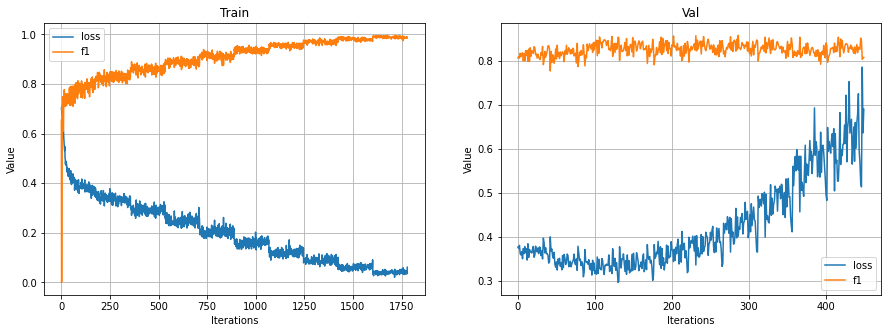

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Как видим, модель переобучается, давайте добавим дропаутов

In [ ]:
class FirstCNN1(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pretrained_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.embedding.weight.requires_grad = False
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.conv = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5) # дропаут
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)

        concat = self.dropout(self.pooling(self.relu(self.conv(concat)))) # дропаут
        pooling = concat.max(2)[0] 

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
set_seed(42)

model = FirstCNN1(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.44099350022465994, Train metric: 0.7451006174087524
Val loss: 0.37851070165634154, Val metric: 0.8080952763557434
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.34823202751995475, Train metric: 0.8186434507369995
Val loss: 0.35158515440093147, Val metric: 0.8103910088539124
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.30920904288800916, Train metric: 0.8468406200408936
Val loss: 0.33582759963141545, Val metric: 0.8253516554832458
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.2710877400770616, Train metric: 0.8735414743423462
Val loss: 0.32889215482605827, Val metric: 0.832698404788971
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.23632772149664633, Train metric: 0.8943044543266296
Val loss: 0.3282474590672387, Val metric: 0.8370935320854187
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.20102111677105508, Train metric: 0.913918673992157
Val loss: 0.3372877789868249, Val metri

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


Ну.. мы улучшили, но если посмотреть на лосс, то увидим, что все плохо и мы ОЧЕНЬ переобучаемся

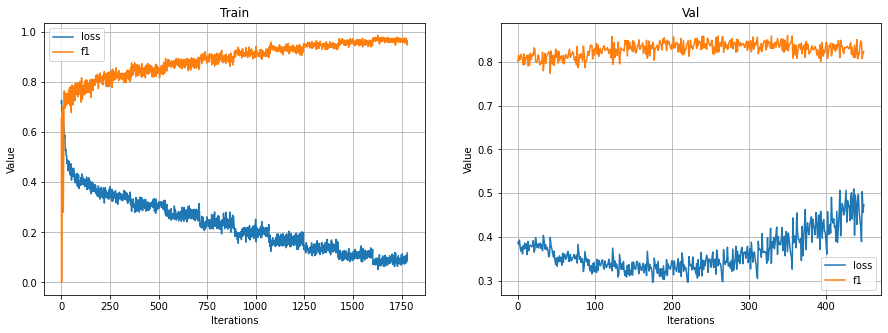

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Кажется, что такая архитектура очень сильно замороченная для таких данных, давайте попробуем ее поменять дальше (см. пункт эксперименты)

In [ ]:
class CNN0(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pretrained_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.embedding.weight.requires_grad = False
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.conv = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)  # дропаут
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.pooling(self.relu(self.bigrams(embedded)))  # пулинг после каждого слоя свертки
        feature_map_trigrams = self.pooling(self.relu(self.trigrams(embedded)))
    
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams ), 1)

        concat = self.dropout(self.pooling(self.relu(self.conv(concat)))) # дропаут
        pooling = concat.max(2)[0] 

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
set_seed(42)

model = CNN0(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.4521992708859819, Train metric: 0.7374106645584106
Val loss: 0.3837537083360884, Val metric: 0.8076916337013245
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.3493405982349696, Train metric: 0.8186271786689758
Val loss: 0.35153107510672676, Val metric: 0.8181459307670593
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.3045085402352087, Train metric: 0.8512195348739624
Val loss: 0.33725041813320583, Val metric: 0.83559250831604
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.2633566760949874, Train metric: 0.8783109784126282
Val loss: 0.33088552554448447, Val metric: 0.8290558457374573
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.22329442973217267, Train metric: 0.9020158648490906
Val loss: 0.33176562984784447, Val metric: 0.8371431231498718
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.1825257404131836, Train metric: 0.9236359596252441
Val loss: 0.3519612100389269, Val metric: 0

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


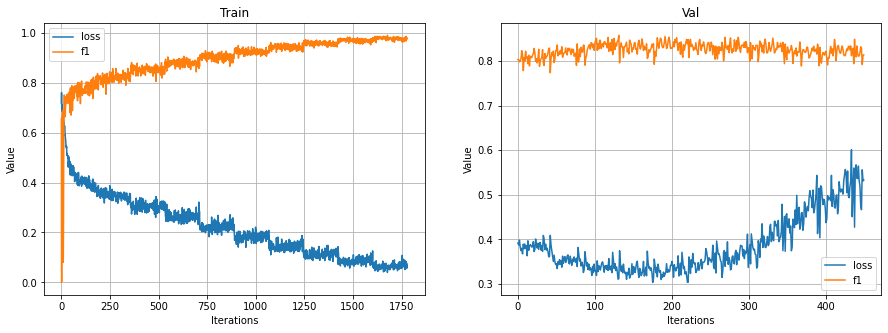

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Все все еще плохо((( давайте уберем слои и добавим больше дропаутов..



In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.embedding.weight.requires_grad = False
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        # добавим дропауты к пулингу после каждого слоя, чтобы уменьшить количество признаков
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded)))) 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))


        # уберем здесь свертку, чтоб не было много слоев.. просто сконкатенируем результаты
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]

        concat = torch.cat((pooling1, pooling2), 1)

        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [ ]:
set_seed(42)

model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.4502189320124937, Train metric: 0.7490966320037842
Val loss: 0.38679704599910314, Val metric: 0.7996737957000732
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.3622998997066798, Train metric: 0.8083367347717285
Val loss: 0.3563683132330577, Val metric: 0.8226363062858582
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.32497310035684135, Train metric: 0.836314857006073
Val loss: 0.33947963317235313, Val metric: 0.8279778957366943
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.29589360182204943, Train metric: 0.8564820289611816
Val loss: 0.33047250840399, Val metric: 0.8272825479507446
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.2690907458910781, Train metric: 0.874306321144104
Val loss: 0.32253966861301, Val metric: 0.8383211493492126
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.24197304843181974, Train metric: 0.8914391398429871
Val loss: 0.3221725755267673, Val metric: 0.841

Посмотрим на графики лосса и метрики

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


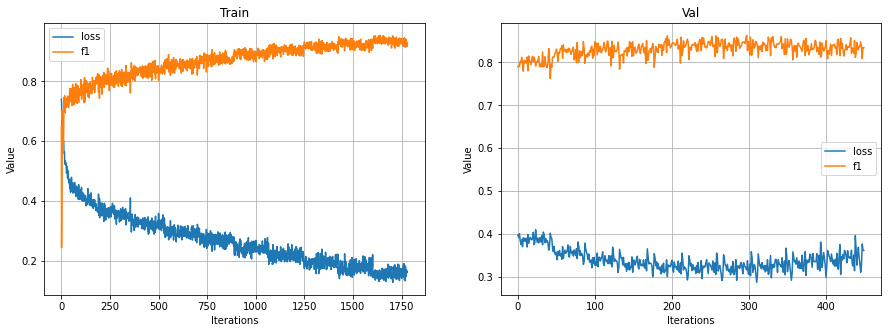

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Как видим, мы улучшили качество, но модель все еще переобучается и лосс на тесте начинает расти

А если добавить веса из ft?

In [ ]:
set_seed(42)

model = CNN(len(word2id), 100, pretrained_weights=ft_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.5640230076701453, Train metric: 0.6982336640357971
Val loss: 0.4722712331347995, Val metric: 0.7491050958633423
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.4492457833852661, Train metric: 0.7447394728660583
Val loss: 0.4373302373621199, Val metric: 0.7703261375427246
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.4246172347430433, Train metric: 0.7607355713844299
Val loss: 0.4188400169213613, Val metric: 0.776587188243866
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.4099569478061762, Train metric: 0.7707599997520447
Val loss: 0.40680854121843973, Val metric: 0.780867338180542
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.39896017748318363, Train metric: 0.7799715399742126
Val loss: 0.3979779574606154, Val metric: 0.7890499830245972
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.39034915439198525, Train metric: 0.7865715622901917
Val loss: 0.3920344048076206, Val metric: 0.7

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


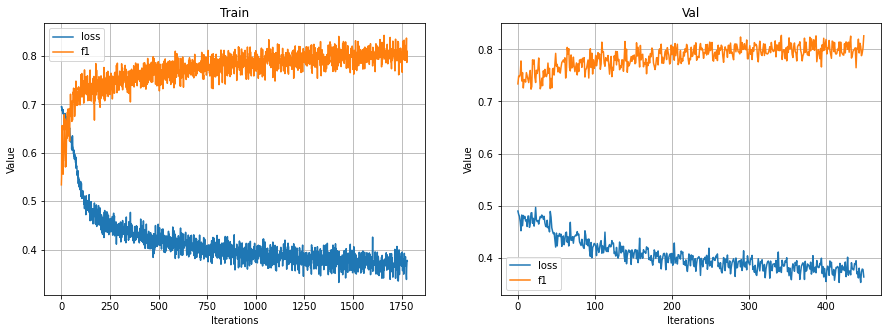

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Эта модель выглядит более многообещающей, потому что вроде нет переобучения,хотя мы кажется пока просто не дошли до этого поинта...


Качество мы конечно улучшили в архитектуре CNN (см предыдущую модель), но хочется сделать, чтобы модель не переобучалась. Давайте поэкспериментируем в конце тетрадки!

# Сетка 2

## Dataloader

In [27]:
sym_vocab = Counter()
for text in data['processed']:
    sym_vocab.update(list(text))
print('всего уникальных слов:', len(sym_vocab))

всего уникальных слов: 447


In [28]:
filtered_sym_vocab = set()

for word in sym_vocab:
    if vocab[word] > 1:
        filtered_sym_vocab.add(word)
print('уникальных символов, втретившихся больше 1 раза:', len(filtered_sym_vocab))

уникальных символов, втретившихся больше 1 раза: 236


In [29]:
symbol2id = {'PAD':0, 'UNK': 1}  # добавим unk т.к. отфильтровали 

for word in filtered_sym_vocab:
    symbol2id[word] = len(symbol2id)

id2symbol = {i:word for word, i in symbol2id.items()}

In [30]:
class WordSymbDataset(Dataset):
    def __init__(self, dataset, word2id, symb2id, DEVICE):
        self.dataset = dataset['processed'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['label'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] if symbol in symbol2id else symbol2id['UNK'] for symbol in symbols])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch):
      word_ids, symb_ids, y = list(zip(*batch))
      padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symb_ids = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_word_ids, padded_symb_ids, y

In [31]:
train_dataset = WordSymbDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [32]:
val_dataset = WordSymbDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

## Архитектура

In [33]:
class FirstWordSymbCNN(nn.Module):
    def __init__(self, word_vocab_size, symb_vocab_size,
                 word_embedding_dim, symb_embedding_dim,
                 pretrained_weights=None):
        super().__init__()

        # word part of the CNN
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        if pretrained_weights is not None:
            self.word_embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.word_embedding.weight.requires_grad = False
        self.f1 = nn.Linear(in_features=word_embedding_dim, out_features=180)

        # symbol part of the CNN
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=360, out_features=1)
        self.out = nn.Sigmoid()
    
    def forward(self, sentence, symbols):
        # word part of the CNN
        embedded_sent = self.word_embedding(sentence).mean(axis=1)
        embedded_sent = self.f1(embedded_sent)

        # symbol part of the CNN
        embedded_symb = self.symb_embedding(symbols)
        embedded_symb = embedded_symb.transpose(1,2)
        feature_map_bigrams = self.pooling(self.relu(self.bigrams(embedded_symb)))
        feature_map_trigrams = self.pooling(self.relu(self.trigrams(embedded_symb)))
        
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]

        # connect all
        concat = torch.cat((pooling1, pooling2, embedded_sent), 1)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [ ]:
set_seed(42)

model = FirstWordSymbCNN(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.5913045911976461, Train metric: 0.6655797362327576
Val loss: 0.45356979767481487, Val metric: 0.7695884704589844
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.38656274555774217, Train metric: 0.8148211240768433
Val loss: 0.3731014801396264, Val metric: 0.8286001682281494
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.310844049527404, Train metric: 0.8551434874534607
Val loss: 0.3465835644139184, Val metric: 0.8344258069992065
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.26678202837035897, Train metric: 0.879033625125885
Val loss: 0.35790715482499863, Val metric: 0.8412838578224182
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.2334494548064939, Train metric: 0.8972817063331604
Val loss: 0.36545062528716193, Val metric: 0.8187113404273987
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.20461332672432567, Train metric: 0.9131686687469482
Val loss: 0.36107128196292454, Val metric:

In [34]:
# сохраним результат
initial_ws_cnn_f1 = 0.8305817246437073

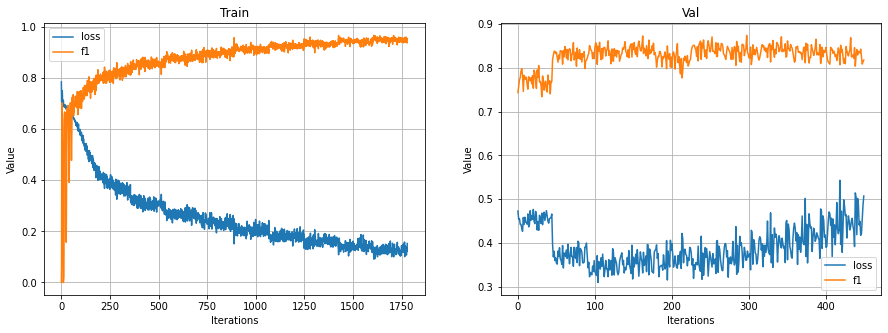

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Ожидаемо после экспериментов с моделью 1, все переобучается, давайте попробуем добавить веса ft

In [ ]:
set_seed(42)

model = FirstWordSymbCNN(len(word2id), len(symbol2id), 100, 10, ft_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.6375366191515762, Train metric: 0.6213308572769165
Val loss: 0.5656502352820503, Val metric: 0.7064681053161621
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.5334008093295473, Train metric: 0.7203611135482788
Val loss: 0.5130516721142663, Val metric: 0.7446210980415344
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.5047131564175145, Train metric: 0.7391852736473083
Val loss: 0.5024478442139095, Val metric: 0.7241353988647461
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.4938339586003443, Train metric: 0.746721088886261
Val loss: 0.4924066285292307, Val metric: 0.74979567527771
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.4856586789482095, Train metric: 0.753423273563385
Val loss: 0.4879585882027944, Val metric: 0.767088770866394
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.4794529431991363, Train metric: 0.7583693861961365
Val loss: 0.4803708877828386, Val metric: 0.7629995

In [ ]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


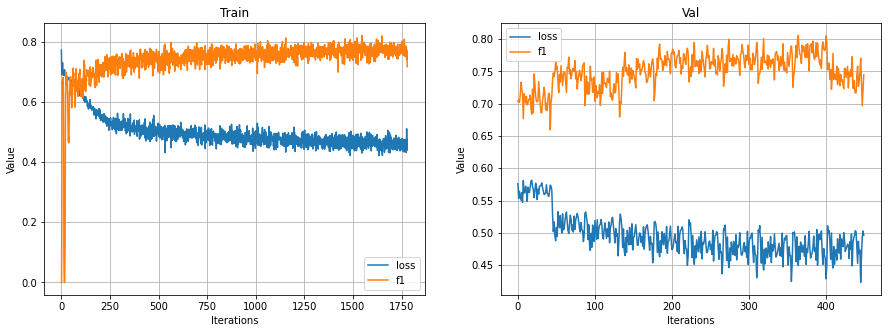

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Как и с первой сеткой, предобученные веса не помогли( В конце тетрадки попробуем улучшить эту модель

# Эксперименты

## Эксперименты Модель 1

Тут будем пытаться улучшить качество наших моделей

In [ ]:
train_dataset = TweetDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = TweetDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

### Эпохи

Попробуем поподбирать параметры для CNN модели (лучшей из тех, что есть, но все еще переобучающейся)

Сначала добавим эпох? 

In [ ]:
set_seed(42)
model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=15,
                                               metric=f1)

Training...


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.4502189320124937, Train metric: 0.7490966320037842
Val loss: 0.38679704599910314, Val metric: 0.7996737957000732
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.3622998997066798, Train metric: 0.8083367347717285
Val loss: 0.3563683132330577, Val metric: 0.8226363062858582
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.32497310035684135, Train metric: 0.836314857006073
Val loss: 0.33947963317235313, Val metric: 0.8279778957366943
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.29589360182204943, Train metric: 0.8564820289611816
Val loss: 0.33047250840399, Val metric: 0.8272825479507446
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.2690907458910781, Train metric: 0.874306321144104
Val loss: 0.32253966861301, Val metric: 0.8383211493492126
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.24197304843181974, Train metric: 0.8914391398429871
Val loss: 0.3221725755267673, Val metric: 0.841

In [ ]:
print('initial_pred:', initial_cnn_f1)

initial_pred: 0.8284485936164856


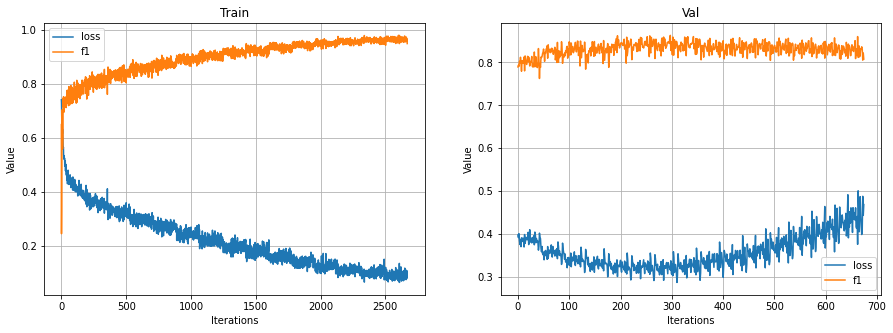

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Ожидаемо, модель просто переобучилась еще больше)) так что будем делать что-то другое

### Scheduler
Попробуем scheduler lr

In [ ]:
set_seed(42)
model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=20,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.4502189320124937, Train metric: 0.7490966320037842
Val loss: 0.38679704599910314, Val metric: 0.7996737957000732
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.3622998997066798, Train metric: 0.8083367347717285
Val loss: 0.3563683132330577, Val metric: 0.8226363062858582
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.32497310035684135, Train metric: 0.836314857006073
Val loss: 0.33947963317235313, Val metric: 0.8279778957366943
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.29589360182204943, Train metric: 0.8564820289611816
Val loss: 0.33047250840399, Val metric: 0.8272825479507446
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.2690907458910781, Train metric: 0.874306321144104
Val loss: 0.32253966861301, Val metric: 0.8383211493492126
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.24197304843181974, Train metric: 0.8914391398429871
Val loss: 0.3221725755267673, Val metric: 0.841

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


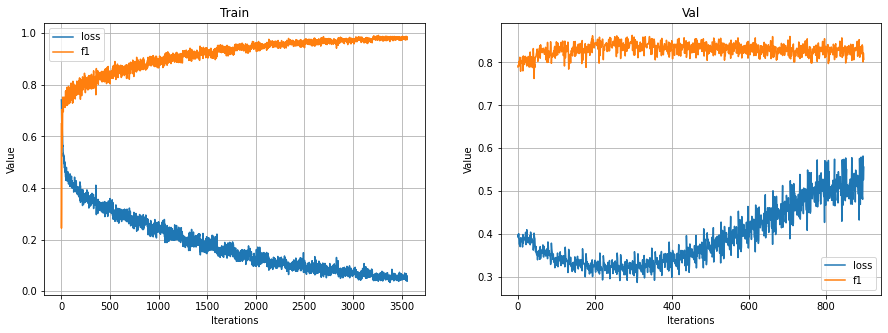

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Другой scheduler?

In [ ]:
set_seed(42)

epochs = 20
lr_lambda = lambda epoch: (epochs - epoch) / epochs

model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=epochs,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.4502189320124937, Train metric: 0.7490966320037842
Val loss: 0.38679704599910314, Val metric: 0.7996737957000732
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.3627116060658787, Train metric: 0.8081310391426086
Val loss: 0.35697430703375077, Val metric: 0.8214892745018005
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.3263626162255748, Train metric: 0.8355358839035034
Val loss: 0.3411484056048923, Val metric: 0.8260690569877625
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.2999136501483703, Train metric: 0.854461669921875
Val loss: 0.3317492279741499, Val metric: 0.8293836712837219
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.27563732485757786, Train metric: 0.8701087832450867
Val loss: 0.32552916871176824, Val metric: 0.8387089371681213
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.2531874282808786, Train metric: 0.8845116496086121
Val loss: 0.3239970280064477, Val metric: 0

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


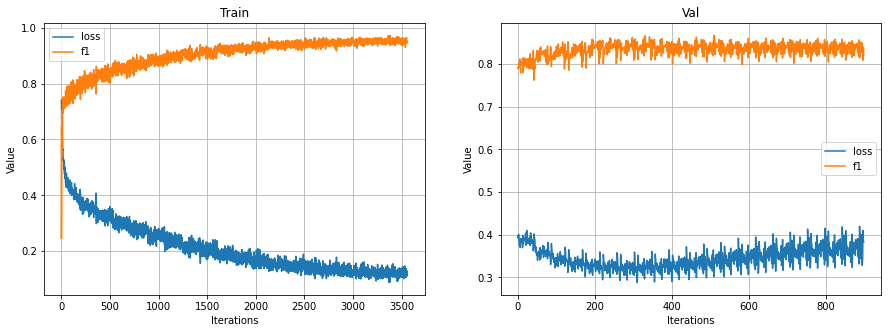

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

### LR

А если уменьшить lr?

In [ ]:
set_seed(42)

epochs = 20
lr_lambda = lambda epoch: (epochs - epoch) / epochs

model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=epochs,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Epoch 1:
Train loss: 0.6002110977855961, Train metric: 0.670360803604126
Val loss: 0.5336077716615465, Val metric: 0.7485443353652954
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.48772491782568816, Train metric: 0.7418991327285767
Val loss: 0.467538317044576, Val metric: 0.7680369019508362
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.44755818954344545, Train metric: 0.7567113041877747
Val loss: 0.43923622171084087, Val metric: 0.7764320373535156
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.42679829259267016, Train metric: 0.7682732343673706
Val loss: 0.4233398636182149, Val metric: 0.778838038444519
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.4130477819884761, Train metric: 0.7758053541183472
Val loss: 0.41265487207306756, Val metric: 0.7830747961997986
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.4029872752307506, Train metric: 0.7818679213523865
Val loss: 0.4047592944569058, Val metric: 0.

In [ ]:
print('initial', initial_cnn_f1)

initial 0.8284485936164856


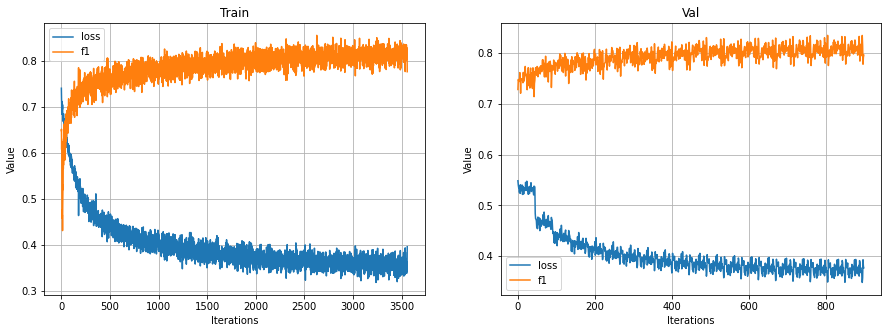

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Выглядит получше, но мы кажется просто не доходим до точки переобучения.. Добавим эпох?

In [ ]:
set_seed(42)

epochs = 40
lr_lambda = lambda epoch: (epochs - epoch) / epochs

model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=epochs,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.6002110977855961, Train metric: 0.670360803604126
Val loss: 0.5336077716615465, Val metric: 0.7485443353652954
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.48710837658871425, Train metric: 0.7420168519020081
Val loss: 0.466489448149999, Val metric: 0.768197774887085
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.446232928151495, Train metric: 0.7573650479316711
Val loss: 0.4375538455115424, Val metric: 0.777319073677063
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.42483718843942275, Train metric: 0.7689387202262878
Val loss: 0.42110958761639067, Val metric: 0.7793998718261719
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.4104598382215821, Train metric: 0.7770894169807434
Val loss: 0.40991045435269674, Val metric: 0.7830071449279785
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.39965421848752525, Train metric: 0.7839653491973877
Val loss: 0.4014849656158023, Val metric: 0.79

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


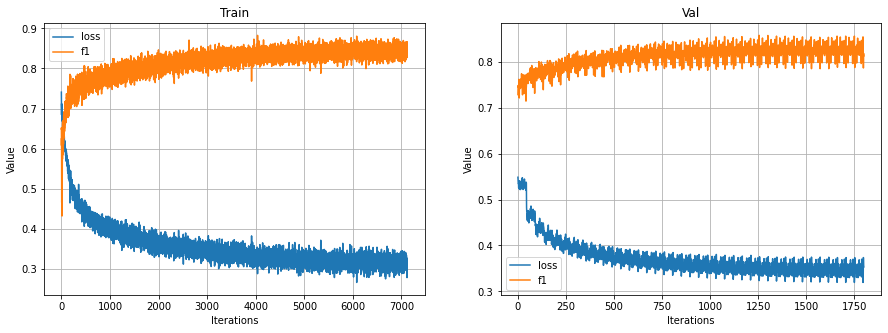

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

уходим в плато(
а с другим расписанием?

In [ ]:
set_seed(42)
model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=40,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.6002110977855961, Train metric: 0.670360803604126
Val loss: 0.5336077716615465, Val metric: 0.7485443353652954
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.4865046493457944, Train metric: 0.7422397136688232
Val loss: 0.4654650482866499, Val metric: 0.768340528011322
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.44495983924088855, Train metric: 0.7581474184989929
Val loss: 0.43593836360507543, Val metric: 0.7776017189025879
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.4229489422581169, Train metric: 0.7699404358863831
Val loss: 0.4189967996544308, Val metric: 0.779508113861084
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.4080126319038734, Train metric: 0.7783043384552002
Val loss: 0.4073353356785244, Val metric: 0.7842440009117126
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.3965388603424758, Train metric: 0.7860748767852783
Val loss: 0.3984714527924856, Val metric: 0.792

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


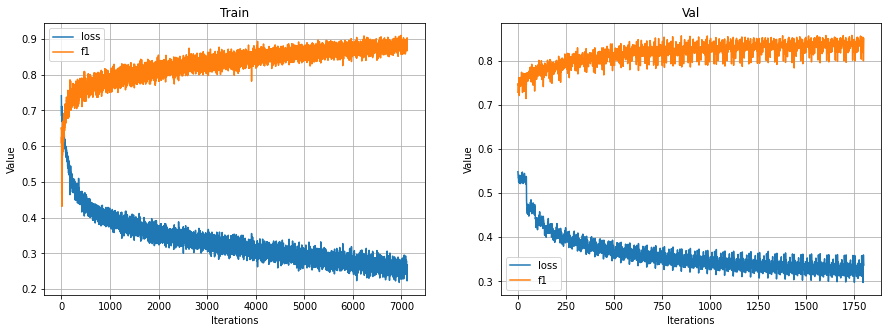

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

### Размерность
Не очень помогло( Попробуем поменять размерность эмбеддингов?

In [ ]:
set_seed(42)
loss_dict = []

for EMB_DIM in [10, 30, 50, 80, 100, 300]:
    print(f'emb_dim={EMB_DIM}')

    model = CNN(len(word2id), EMB_DIM)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


    train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                                val_dataloader=val_iterator,
                                                model=model,
                                                optimizer=optimizer,
                                                criterion=criterion,
                                                epochs=20,
                                                metric=f1)
    
    loss_dict.append({'emb_dim': EMB_DIM,
                      'train_loss': train_loss,
                      'val_loss': val_loss,
                      'train_f1': train_f1,
                      'val_f1': val_f1,
                      'model': model})
    print('initial:', initial_cnn_f1)
    print()
    print()

emb_dim=10
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.657350675443585, Train metric: 0.6128082871437073
Val loss: 0.5795471323861017, Val metric: 0.7322721481323242
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.5207710174027453, Train metric: 0.7280034422874451
Val loss: 0.46796050866444905, Val metric: 0.7699733376502991
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.4373384352480428, Train metric: 0.7705066204071045
Val loss: 0.4169770836830139, Val metric: 0.7911736369132996
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.3961352670795462, Train metric: 0.7913137078285217
Val loss: 0.3901792950100369, Val metric: 0.7927230596542358
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.3694138312607669, Train metric: 0.8070762753486633
Val loss: 0.37515514095624286, Val metric: 0.8042382001876831
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.3491204206863146, Train metric: 0.8209715485572815
Val loss: 0.3647588597403632, Val metric: 0.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.5282220473785079, Train metric: 0.7092035412788391
Val loss: 0.44244902200169034, Val metric: 0.7735539674758911
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.4123853488584583, Train metric: 0.7762764692306519
Val loss: 0.39597569041781955, Val metric: 0.7930245399475098
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.3722407961829325, Train metric: 0.8024530410766602
Val loss: 0.3741596069600847, Val metric: 0.8068984746932983
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.34499981279453534, Train metric: 0.8213046789169312
Val loss: 0.358824309375551, Val metric: 0.8136963844299316
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.3225172552165021, Train metric: 0.8370858430862427
Val loss: 0.3494034495618608, Val metric: 0.8151540756225586
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.3028444383251533, Train metric: 0.852118730545044
Val loss: 0.3427129109700521, Val metric: 0.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.49064826429559943, Train metric: 0.7294164299964905
Val loss: 0.41957136789957683, Val metric: 0.7823074460029602
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.39305301010608673, Train metric: 0.7882344126701355
Val loss: 0.3792916774749756, Val metric: 0.7995131611824036
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.3560204527686151, Train metric: 0.8133829236030579
Val loss: 0.35975715981589423, Val metric: 0.819667637348175
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.3272449210118712, Train metric: 0.8349094390869141
Val loss: 0.349345506562127, Val metric: 0.8290106058120728
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.30321515996134685, Train metric: 0.8524128794670105
Val loss: 0.33758451806174383, Val metric: 0.8232977986335754
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.28248066781611925, Train metric: 0.8655555844306946
Val loss: 0.33150727881325615, Val metric

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.454526547802968, Train metric: 0.7441856861114502
Val loss: 0.39412826498349507, Val metric: 0.7906855344772339
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.3704488945476125, Train metric: 0.8008210062980652
Val loss: 0.36290231347084045, Val metric: 0.8205835819244385
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.3352793054969123, Train metric: 0.8282175064086914
Val loss: 0.344528341293335, Val metric: 0.8259511590003967
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.30583651497792663, Train metric: 0.8497002124786377
Val loss: 0.33250525328848096, Val metric: 0.8304692506790161
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.28129703199930406, Train metric: 0.8661965131759644
Val loss: 0.32688366373380023, Val metric: 0.837651252746582
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.25799705205338724, Train metric: 0.8804076313972473
Val loss: 0.323453074031406, Val metric: 0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.4535615186343032, Train metric: 0.745458722114563
Val loss: 0.3895010756121741, Val metric: 0.79810631275177
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.3647574509462614, Train metric: 0.8046755194664001
Val loss: 0.35804636743333607, Val metric: 0.8175297379493713
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.3273634942394964, Train metric: 0.8344067931175232
Val loss: 0.3394375562667847, Val metric: 0.8289415836334229
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.29516994886184006, Train metric: 0.8567060232162476
Val loss: 0.3292705708079868, Val metric: 0.8326781988143921
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.26880686931060943, Train metric: 0.8743987083435059
Val loss: 0.3233014298809899, Val metric: 0.8370539546012878
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.24326541969615423, Train metric: 0.8898051977157593
Val loss: 0.3225340723991394, Val metric: 0.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.40975036246053287, Train metric: 0.769983172416687
Val loss: 0.3614877416027917, Val metric: 0.824979841709137
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.32828142117248493, Train metric: 0.8325088024139404
Val loss: 0.33524793254004587, Val metric: 0.8332553505897522
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.28495160992560764, Train metric: 0.8634705543518066
Val loss: 0.3217626081572639, Val metric: 0.8417707681655884
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.24518715464666987, Train metric: 0.8881708979606628
Val loss: 0.3213248994615343, Val metric: 0.8458802103996277
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.20703804869665188, Train metric: 0.9100719094276428
Val loss: 0.3210345188776652, Val metric: 0.845632791519165
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.1726161925477928, Train metric: 0.927737295627594
Val loss: 0.3299327896700965, Val metric: 0.

emb_dim=10


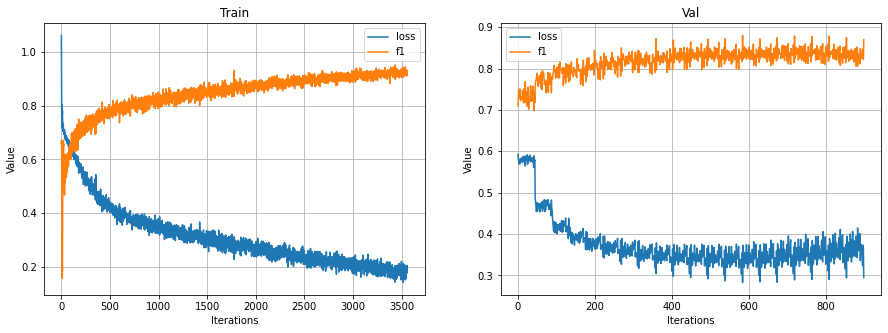

emb_dim=30


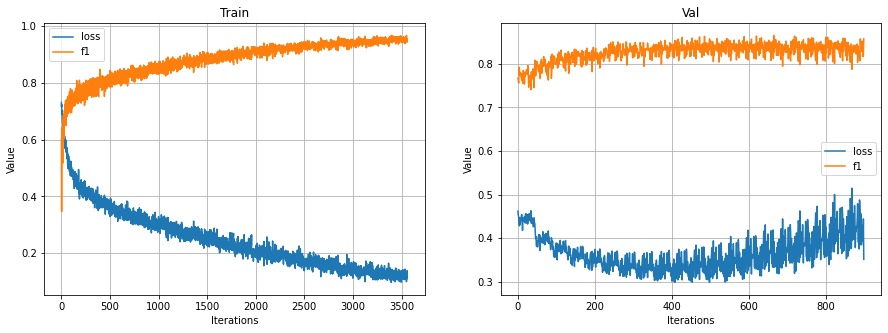

emb_dim=50


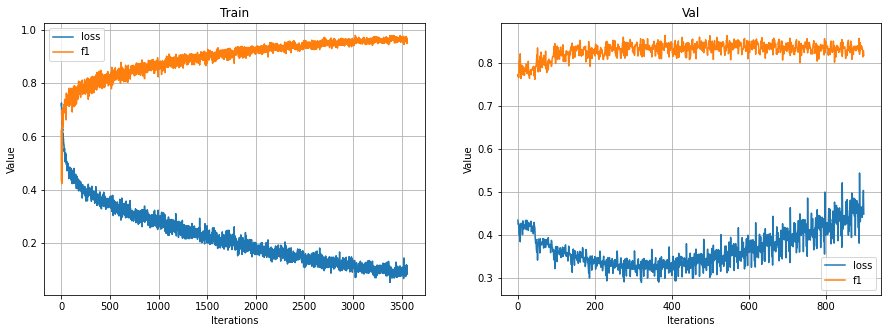

emb_dim=80


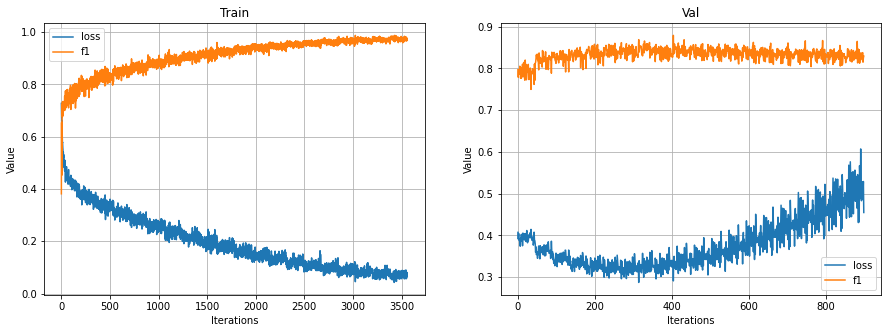

emb_dim=100


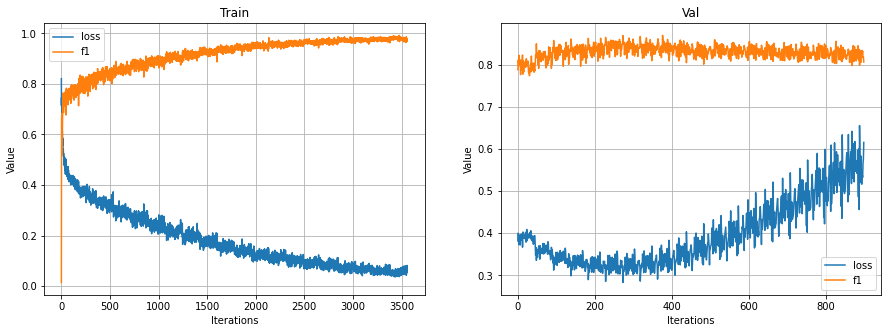

emb_dim=300


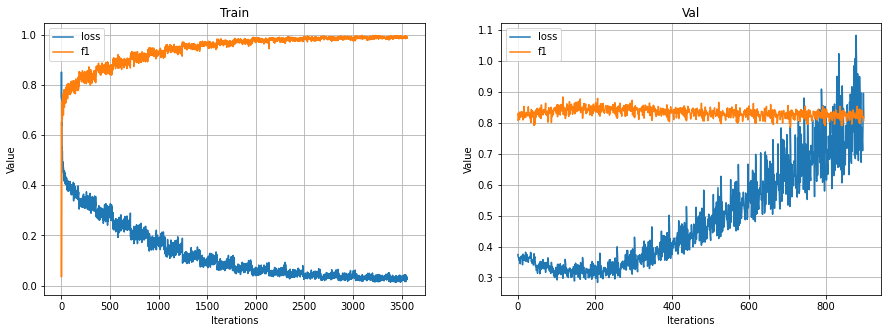

In [ ]:
for training in loss_dict:
   print(f'emb_dim={training["emb_dim"]}')
   plot_training(training['train_loss'], training['train_f1'], training['val_loss'], training['val_f1'])
   plt.show()

### DropOut

Ну,очевидно так просто параметрами не решить проблему переобучения, поэтому будем дальше менять архитектуру модели:

In [ ]:
class CNN2(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.7) # увеличим дропаут
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))

        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2), 1)

        concat = self.dropout(concat) # добавим дропаут, чтобы нейроны не переобучались
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits
      

In [ ]:
set_seed(42)
model = CNN2(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=40,
                                               metric=f1)

Training...


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.9275450043463975, Train metric: 0.5478206872940063
Val loss: 0.6233939197328355, Val metric: 0.7372292280197144
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.7278371945525823, Train metric: 0.6102686524391174
Val loss: 0.5791406525505913, Val metric: 0.7505929470062256
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.6382822250382284, Train metric: 0.6523475050926208
Val loss: 0.54992116689682, Val metric: 0.7591135501861572
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.5888037286447675, Train metric: 0.6772506833076477
Val loss: 0.5293091932932535, Val metric: 0.7648218870162964
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.5560814326398829, Train metric: 0.6945697069168091
Val loss: 0.5128966285122766, Val metric: 0.7673338055610657
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.5338005192494124, Train metric: 0.7076836228370667
Val loss: 0.4988822519779205, Val metric: 0.7718

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


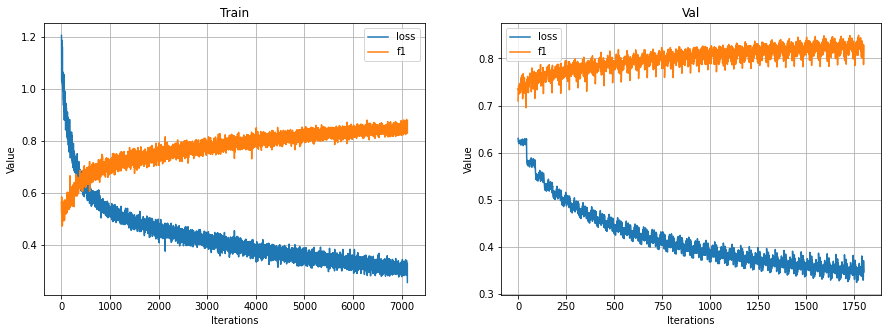

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

In [ ]:
set_seed(42)
model = CNN2(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=40,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.9275450043463975, Train metric: 0.5478206872940063
Val loss: 0.6233939197328355, Val metric: 0.7372292280197144
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.7278371945525823, Train metric: 0.6102686524391174
Val loss: 0.5791406525505913, Val metric: 0.7505929470062256
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.6382822250382284, Train metric: 0.6523475050926208
Val loss: 0.54992116689682, Val metric: 0.7591135501861572
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.5888037286447675, Train metric: 0.6772506833076477
Val loss: 0.5293091932932535, Val metric: 0.7648218870162964
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.5560814326398829, Train metric: 0.6945697069168091
Val loss: 0.5128966285122766, Val metric: 0.7673338055610657
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.5338005192494124, Train metric: 0.7076836228370667
Val loss: 0.4988822519779205, Val metric: 0.7718

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


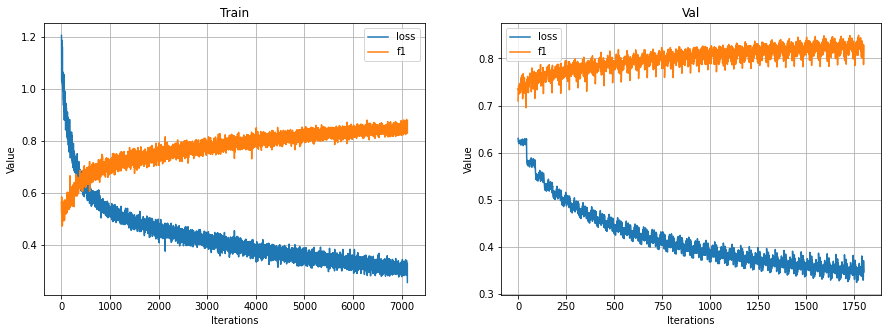

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

### Нормализация

In [ ]:
class CNN3(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # добавим нормализацию
        self.batch_bi = nn.BatchNorm1d(100) 
        self.batch_tri = nn.BatchNorm1d(80) 

        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))

        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]

        # добавим нормализацию
        pooling1 = self.batch_bi(pooling1)
        pooling2 = self.batch_tri(pooling2)

        concat = torch.cat((pooling1, pooling2), 1)
        
        concat = self.dropout(concat)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits
      

In [ ]:
set_seed(42)
model = CNN3(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.46402161158202737, Train metric: 0.7415841817855835
Val loss: 0.39802452325820925, Val metric: 0.7385118007659912
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.383287130614345, Train metric: 0.7899850606918335
Val loss: 0.38008843925264146, Val metric: 0.8145887851715088
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.35554658144377593, Train metric: 0.8139339685440063
Val loss: 0.3589974966314104, Val metric: 0.8274840712547302
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.3317115966523631, Train metric: 0.831951379776001
Val loss: 0.3406052463584476, Val metric: 0.816207230091095
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.308360987165001, Train metric: 0.8483550548553467
Val loss: 0.3321206238534715, Val metric: 0.8381773829460144
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.2857873578754704, Train metric: 0.8638732433319092
Val loss: 0.33366712464226617, Val metric: 0.8

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


Ура? ну это небольшое, но улучшение...

попробуем еще scheduler и другой lr

In [ ]:
set_seed(42)
model = CNN3(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=20,
                                               metric=f1, 
                                               scheduler=scheduler)

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.5043686047363817, Train metric: 0.7216435074806213
Val loss: 0.4455384333928426, Val metric: 0.6370760798454285
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.4096781047207586, Train metric: 0.7716512084007263
Val loss: 0.4086641417609321, Val metric: 0.8002965450286865
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.38519646645931716, Train metric: 0.7891413569450378
Val loss: 0.39673816826608443, Val metric: 0.8056282997131348
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.36816375342647684, Train metric: 0.803774356842041
Val loss: 0.35985750158627827, Val metric: 0.8186628818511963
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.35427504258879117, Train metric: 0.8139597177505493
Val loss: 0.3640268570846982, Val metric: 0.8237284421920776
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.3416445076130749, Train metric: 0.8231909275054932
Val loss: 0.3829591393470764, Val metric: 

In [ ]:
print('initial:', initial_cnn_f1)

initial: 0.8284485936164856


класс!
не много, но уже хорошо, пока оставим эту модель и перейдем к другой

## Эксперименты Модель 2

Попробуем улучшить модель с символьными и пословными представлениями

P.s. Если честно, я уже устала от экспериментов, а вы наверняка устали это все смотреть и читать, так что оставлю тут самые показательные запуски..

In [35]:
train_dataset = WordSymbDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = WordSymbDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [36]:
class WordSymbCNN(nn.Module):
    def __init__(self, word_vocab_size, symb_vocab_size,
                 word_embedding_dim, symb_embedding_dim,
                 pretrained_weights=None):
        super().__init__()

        # word part of the CNN
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        if pretrained_weights is not None:
            self.word_embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.word_embedding.weight.requires_grad = False
        self.f1 = nn.Linear(in_features=word_embedding_dim, out_features=180)

        # symbol part of the CNN
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=360, out_features=1)
        self.dropout = nn.Dropout(p=0.5)  # добавим дропаут
        self.out = nn.Sigmoid()
    
    def forward(self, sentence, symbols):
        # word part of the CNN
        embedded_sent = self.word_embedding(sentence).mean(axis=1)
        embedded_sent = self.f1(embedded_sent)

        # symbol part of the CNN
        embedded_symb = self.symb_embedding(symbols)
        embedded_symb = embedded_symb.transpose(1,2) 
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded_symb))))  # добавим дропаут
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded_symb))))
        
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]

        # connect all
        concat = torch.cat((pooling1, pooling2, embedded_sent), 1)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [ ]:
set_seed(42)

model = WordSymbCNN(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.6229385589615682, Train metric: 0.6459299921989441
Val loss: 0.49785219497150845, Val metric: 0.7261720299720764
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.40117112421587614, Train metric: 0.8098854422569275
Val loss: 0.37584875689612496, Val metric: 0.8192225694656372
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.31559822649768227, Train metric: 0.853207528591156
Val loss: 0.3538773265149858, Val metric: 0.8228446245193481
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.2696276101168622, Train metric: 0.8776116371154785
Val loss: 0.3474119140042199, Val metric: 0.8377003073692322
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.23612309916970436, Train metric: 0.8960029482841492
Val loss: 0.3873033841451009, Val metric: 0.8008071780204773
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.20709945387050008, Train metric: 0.9116291403770447
Val loss: 0.36072553793589274, Val metric

In [ ]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


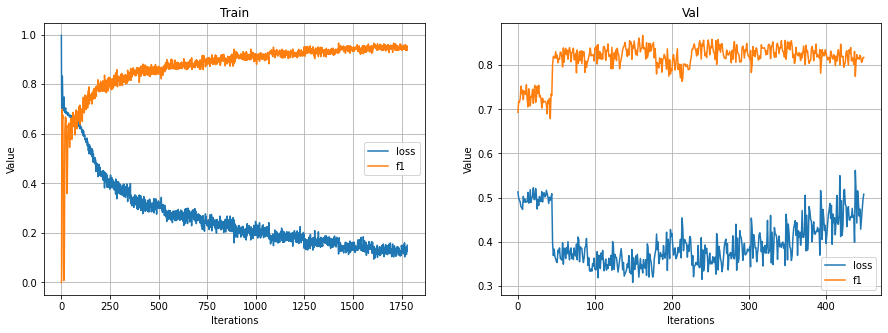

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Ну и ладно..

Тут кажется и так понятно, что таким простым изменением не управиться. Так что будем улучшать дальше

### Scheduler

In [ ]:
set_seed(42)
model = WordSymbCNN(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=15,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.7042655998401428, Train metric: 0.5001534223556519
Val loss: 0.6818060146437751, Val metric: 0.6196632981300354
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.671847711453277, Train metric: 0.6129468679428101
Val loss: 0.6646117051442464, Val metric: 0.6629245281219482
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.6483040117145924, Train metric: 0.6638500690460205
Val loss: 0.6369805720117357, Val metric: 0.7079258561134338
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.6131442889068903, Train metric: 0.7050941586494446
Val loss: 0.5979490783479479, Val metric: 0.7133371233940125
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.5690288205495041, Train metric: 0.7352797389030457
Val loss: 0.5575051479869418, Val metric: 0.7107455134391785
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.5258734386958434, Train metric: 0.756142795085907
Val loss: 0.5191528326935239, Val metric: 0.7394

In [ ]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


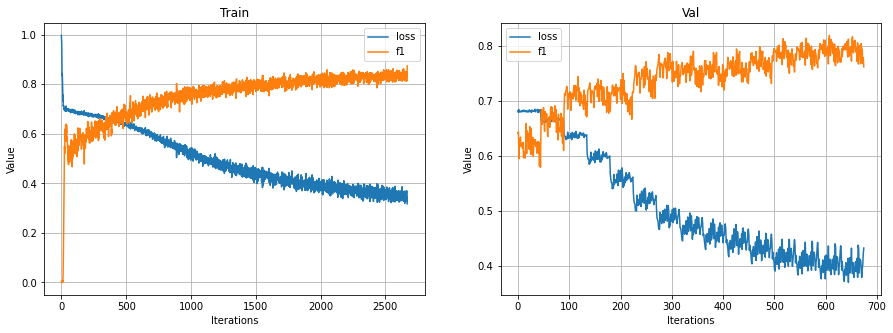

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

In [ ]:
set_seed(42)
epochs=15
lr_lambda = lambda epoch: (epochs - epoch) / epochs

model = WordSymbCNN(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=epochs,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.7042655998401428, Train metric: 0.5001534223556519
Val loss: 0.6818060146437751, Val metric: 0.6196632981300354
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.6724699792567264, Train metric: 0.611120343208313
Val loss: 0.6658862034479777, Val metric: 0.6646679639816284
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.6518964245078269, Train metric: 0.6583582162857056
Val loss: 0.6432296541002062, Val metric: 0.7018687129020691
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.6245490928714195, Train metric: 0.6946743726730347
Val loss: 0.614092206954956, Val metric: 0.7089517116546631
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.5924801689185454, Train metric: 0.7218576669692993
Val loss: 0.5856748660405476, Val metric: 0.6896384358406067
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.5610784014289298, Train metric: 0.7394412755966187
Val loss: 0.5572674393653869, Val metric: 0.7134

In [ ]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


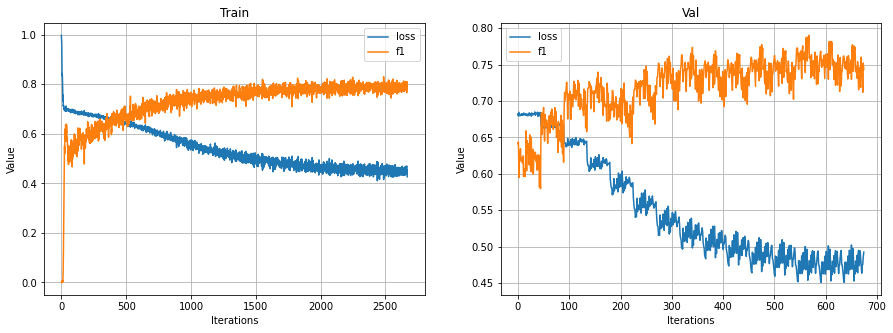

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

### Дропаут

In [37]:
class WordSymbCNN2(nn.Module):
    def __init__(self, word_vocab_size, symb_vocab_size,
                 word_embedding_dim, symb_embedding_dim,
                 pretrained_weights=None):
        super().__init__()

        # word part of the CNN
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        if pretrained_weights is not None:
            self.word_embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.word_embedding.weight.requires_grad = False
        self.f1 = nn.Linear(in_features=word_embedding_dim, out_features=180)

        # symbol part of the CNN
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=360, out_features=1)
        self.dropout = nn.Dropout(p=0.7)  # увеличим дропаут
        self.out = nn.Sigmoid()
    
    def forward(self, sentence, symbols):
        # word part of the CNN
        embedded_sent = self.word_embedding(sentence).mean(axis=1)
        embedded_sent = self.f1(embedded_sent)

        # symbol part of the CNN
        embedded_symb = self.symb_embedding(symbols)
        embedded_symb = embedded_symb.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded_symb))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded_symb))))
        
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]

        # connect all
        concat = torch.cat((pooling1, pooling2, embedded_sent), 1)
        concat = self.dropout(concat) # и сюда добавим дропаут
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [ ]:
set_seed(42)

model = WordSymbCNN2(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=20,
                                               metric=f1)

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.7505084048496203, Train metric: 0.5976482629776001
Val loss: 0.5380341702037388, Val metric: 0.683861255645752
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.4355021755347091, Train metric: 0.7930469512939453
Val loss: 0.3924436502986484, Val metric: 0.8055009841918945
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.33773618802595673, Train metric: 0.841846227645874
Val loss: 0.365358657307095, Val metric: 0.8107808232307434
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.2887174683005622, Train metric: 0.8682155013084412
Val loss: 0.3585881339179145, Val metric: 0.8166022300720215
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.2523146704509017, Train metric: 0.8880622386932373
Val loss: 0.3690555810928345, Val metric: 0.8118868470191956
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.22398680398303472, Train metric: 0.9027740955352783
Val loss: 0.362988766696718, Val metric: 0.8272

In [ ]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


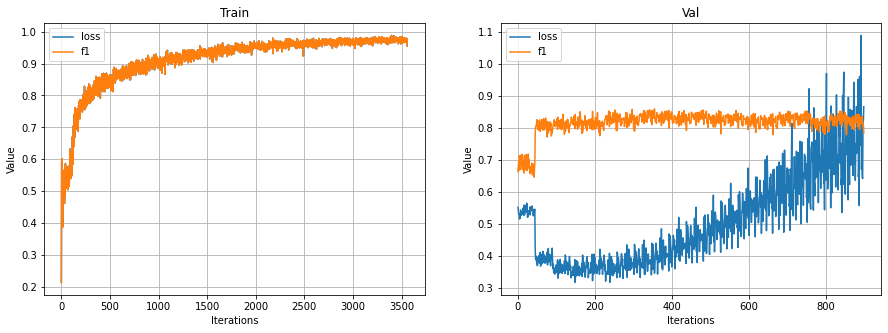

In [ ]:
plot_training(train_f1, train_f1, val_loss, val_f1)

### Нормализация

In [38]:
class WordSymbCNN3(nn.Module):
    def __init__(self, word_vocab_size, symb_vocab_size,
                 word_embedding_dim, symb_embedding_dim,
                 pretrained_weights=None):
        super().__init__()

        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        if pretrained_weights is not None:
            self.word_embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.word_embedding.weight.requires_grad = False
        self.f1 = nn.Linear(in_features=word_embedding_dim, out_features=180)

        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=360, out_features=1)
        self.dropout = nn.Dropout(p=0.7) # увеличим дропаут

        # добавим нормализацию
        self.batch_bi = nn.BatchNorm1d(100) 
        self.batch_tri = nn.BatchNorm1d(80) 

        self.out = nn.Sigmoid()
    
    def forward(self, sentence, symbols):
        embedded_sent = self.word_embedding(sentence).mean(axis=1)
        embedded_sent = self.f1(embedded_sent)

        embedded_symb = self.symb_embedding(symbols)
        embedded_symb = embedded_symb.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded_symb))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded_symb))))

        # добавим нормализацию
        feature_map_bigrams = self.batch_bi(feature_map_bigrams)
        feature_map_trigrams = self.batch_tri(feature_map_trigrams)
        
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]

        concat = torch.cat((pooling1, pooling2, embedded_sent), 1)
        concat = self.dropout(concat) # добавим дропаут
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [ ]:
set_seed(42)

model = WordSymbCNN3(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=20,
                                               metric=f1)

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.786249090446515, Train metric: 0.6038973331451416
Val loss: 0.5500112189186944, Val metric: 0.631436824798584
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.43365228510974496, Train metric: 0.793801486492157
Val loss: 0.39368417527940536, Val metric: 0.8011214137077332
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.33792109586549607, Train metric: 0.8412688374519348
Val loss: 0.3648916304111481, Val metric: 0.8108975887298584
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.2892885391464394, Train metric: 0.8677546381950378
Val loss: 0.35335949261983235, Val metric: 0.8234535455703735
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.2528382348880339, Train metric: 0.887609601020813
Val loss: 0.37962127063009476, Val metric: 0.8043997287750244
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.22419549750812937, Train metric: 0.9029794931411743
Val loss: 0.36299900015195213, Val metric: 0

In [ ]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


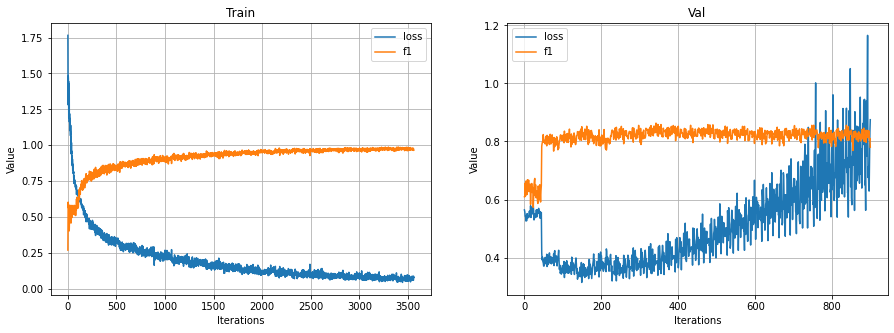

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Ну, видимо нам уже ничего не поможет... Давайте разбираться почему..


## Посмотрим на данные?

In [39]:
data.head()

,index,id,date,author,text,label,repl,rtw,fav,stcount,fols,friends,listcount,processed
0,0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,0,0,0,0,8064,111,94,2,на работе был полный пиддес :| и так каждое за...
1,1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,0,0,0,26,42,39,0,Коллеги сидят рубятся в Urban terror а я из-за...
2,2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,0,0,0,0,718,49,249,0,как говорят обещаного три года ждут ...
3,3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",0,0,0,0,10628,207,200,0,Желаю хорошего полёта и удачной посадки я буду...
4,4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",0,0,0,0,35,17,34,0,Обновил за каким-то лешим surf теперь не работ...


Давайте посмотрим на длинну текстов?

In [40]:
print('min:', data['processed'].apply(lambda x: len(x.split())).min())
print('max:', data['processed'].apply(lambda x: len(x.split())).max())
print('mean:', data['processed'].apply(lambda x: len(x.split())).mean())
print('median:', data['processed'].apply(lambda x: len(x.split())).median())

min: 1
max: 39
mean: 11.876839450875972
median: 11.0


In [41]:
id = data['processed'].apply(lambda x: len(x.split())).argmin()
data['label'][id], data['processed'][id]

(0, 'амазон')

In [42]:
id = np.where(data['processed'].apply(lambda x: len(x.split())) == 1)
id[0].shape

(599,)

In [43]:
data['processed'].to_numpy()[id][:10]

array(['амазон', 'Пиздец', 'Знакомо', 'уооо', 'ЗНАЮ', 'ага', 'жаль',
       'похожи', 'ТАТАТАТАТААТ', 'Несправедливость'], dtype=object)

Как видим, у нас довольно много однословных текстов, которые к тому же ничего почти не говорят нам о тональности отзыва, так что нужно их как-то почистить. подозреваю, что на них модель и ошибается

А если посмотреть на символы?

In [44]:
print('min:', data['processed'].apply(lambda x: len(list(x))).min())
print('max:', data['processed'].apply(lambda x: len(list(x))).max())
print('mean:', data['processed'].apply(lambda x: len(list(x))).mean())
print('median:', data['processed'].apply(lambda x: len(list(x))).median())

min: 1
max: 154
mean: 65.53497271132194
median: 60.0


In [45]:
id = data['processed'].apply(lambda x: len(list(x))).argmin()
data['label'][id], data['processed'][id]

(0, '…')

In [46]:
id = np.where(data['processed'].apply(lambda x: len(list(x))) == 1)
id[0].shape

(9,)

In [47]:
print(data['processed'].to_numpy()[id][:10].tolist())
print(data['text'].to_numpy()[id][:10].tolist())

['…', '…', 'и', '…', 'м', 'З', 'о', 'х', 'С']
['RT @_Batonchik_: @cekc_tyt @aabdullaeva1 @chemicalechelon @frank_james45 @herlocked @misty_marcie @mywhisper @to_over_kill @whoresdiefirst …', 'RT @SolarEclipse57: @girl_turner666 @SCOOB_JOE @Geronimo_woohoo @drinkthecyani @SolarEclipse57 @greennwood @BrianMolko_off @bananacookiee @…', '@hasio_original и @whitebro_ http://t.co/dupuQSnm6D', 'RT @unixOS_ctts: @Mo_OnMery @SimplyShot @_Shavka_ @arbyziik @_tentazione_ @robert_dakota @el_ectro_nick @ligi_chan_ @ser___gay @_humiliatio…', '@Mikky_Acorn @DNO_OKEANA_A3A3 @korelina1999 @chashhixinNic м', '@miroshka_n @AmericanPando @_EGOIST_FUCK_ @Do_Or_Die_xxx @18_marina_g @Nastia_GD :З', '@Juletta163 @SlavaTogliatti @harakiri_killss :о(', 'RT @olesyaglee: @ktyekmrf30 http://t.co/fBbOR9RPLn х)', 'RT @Mariya_Mila: С @ErmachonokAnton ) http://t.co/LmCxpsSoQG']


In [48]:
id = np.where(data['processed'].apply(lambda x: len(list(x))).isin([1, 2, 3]) )
id[0].shape

(77,)

In [49]:
print(data['processed'].to_numpy()[id][:10].tolist())  # отфильтрованные тексты
print(data['text'].to_numpy()[id][:10].tolist())  # оригинальные тексты

['ага', 'уже', 'ага', 'угу', '…', 'и я', 'Лох', 'о_О', 'ззз', 'Нит']
['RT @14Ermakova: ага( http://t.co/YyV0xBljt3', '@AWSMINGVARR уже ( http://t.co/5oJad6mLew', 'RT @14Ermakova: ага( http://t.co/YyV0xBljt3', '@Viktuar1964 @klodneron @ugadajka угу((((((', 'RT @_Batonchik_: @cekc_tyt @aabdullaeva1 @chemicalechelon @frank_james45 @herlocked @misty_marcie @mywhisper @to_over_kill @whoresdiefirst …', '@Katyaaa_fly @Vituska1998 @daria_hey и я(', 'RT @strange_eyes: Лох( http://t.co/vf8AmmIdbd', 'RT @Heart_Tardis: о_О http://t.co/dJ8uuNI72I', 'RT @Sonya_o_o: :ззз http://t.co/nnZDmRb499', 'RT @DASHKA09D: @directioner6922 Нит(( http://t.co/cwt6kFfxmu']


С символами тоже не очень дела, как видим, у нас отфильтровывается много текста включая грустные скобочки, когда твиты отрицательные. 

Давайте попробуем почистить такие тексты, чтобы дать модели шанс! и я бы попробовала лемматизировать, т.к. для классификации тональности кажется форма слова не оченб полезна, зато так мы получим корпус потенциально немного меньше => может быть будет лучше... узнаем!


In [50]:
lemmatizer = MorphAnalyzer()

def preprocess(text):

    tokens = tt.tokenize(text)
    lemmatized = [lemmatizer.parse(t)[0].normal_form for t in tokens if (t not in STOPWORDS  and
                                                                         not t.startswith(('@', 'http')) and
                                                                         t != 'RT')
    ]

    return ' '.join(lemmatized) if len(lemmatized) >= 3 else None # предложения состоящие только из @ и тд нам не нужны, т.к. отфильтруются полностью.. 
    

In [51]:
data['processed'] = data['text'].progress_apply(preprocess)
data.dropna(inplace=True) # теперь дропнем те колонки, где все отфильтровалось

  0%|          | 0/226834 [00:00<?, ?it/s]

In [52]:
data.shape

(224633, 14)

In [53]:
vocab = Counter()
for text in data['processed']:
    vocab.update(text.split())
print('всего уникальных слов:', len(vocab))

word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

всего уникальных слов: 116596


In [54]:
sym_vocab = Counter()
for text in data['processed']:
    sym_vocab.update(list(text))
print('всего уникальных слов:', len(sym_vocab))

filtered_sym_vocab = set()

for word in sym_vocab:
    if vocab[word] > 1:
        filtered_sym_vocab.add(word)
print('уникальных символов, втретившихся больше 1 раза:', len(filtered_sym_vocab))

symbol2id = {'PAD':0, 'UNK': 1}  # добавим unk т.к. отфильтровали 

for word in filtered_sym_vocab:
    symbol2id[word] = len(symbol2id)

id2symbol = {i:word for word, i in symbol2id.items()}

всего уникальных слов: 375
уникальных символов, втретившихся больше 1 раза: 173


In [55]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [56]:
train_dataset = WordSymbDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = WordSymbDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

## Попробуем улучшить результаты на второй модели

In [ ]:
set_seed(42)

model = WordSymbCNN(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=20,
                                               metric=f1)

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.5712930482219566, Train metric: 0.6898555159568787
Val loss: 0.45289265838536347, Val metric: 0.750150740146637
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.37928701242939994, Train metric: 0.8188766241073608
Val loss: 0.3726592477072369, Val metric: 0.8019096851348877
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.31949773024428973, Train metric: 0.8495180010795593
Val loss: 0.3396421772512523, Val metric: 0.8306651711463928
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.28965054046023975, Train metric: 0.8650732636451721
Val loss: 0.3432233381000432, Val metric: 0.8202435970306396
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.2684596125036478, Train metric: 0.8765300512313843
Val loss: 0.34819686345078726, Val metric: 0.8161292672157288
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.2504102493720976, Train metric: 0.8869382739067078
Val loss: 0.3409532376311042, Val metric: 

In [56]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


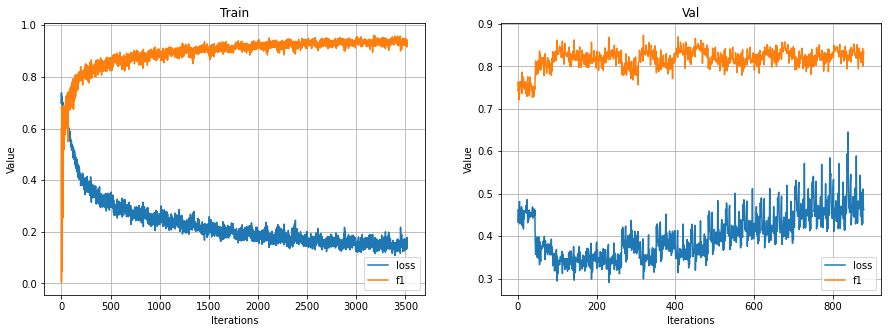

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Пойдем по пройденному пути? добавим sheduler, уменьшим lr и добавим эпох

In [ ]:
set_seed(42)

epochs = 15

model = WordSymbCNN(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=epochs,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.6177750466899439, Train metric: 0.6678211688995361
Val loss: 0.5350062576207247, Val metric: 0.6995330452919006
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.45592792095108464, Train metric: 0.7819128632545471
Val loss: 0.4547651782631874, Val metric: 0.729368269443512
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.3791490021077069, Train metric: 0.8200559020042419
Val loss: 0.38628617403182114, Val metric: 0.794325053691864
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.3403950789096681, Train metric: 0.8387444019317627
Val loss: 0.37339030680331314, Val metric: 0.7972341179847717
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.31508259170434694, Train metric: 0.8519689440727234
Val loss: 0.35250442542813043, Val metric: 0.8161451816558838
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.2979633610018275, Train metric: 0.8602254986763
Val loss: 0.3531696925109083, Val metric: 0.81

In [58]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


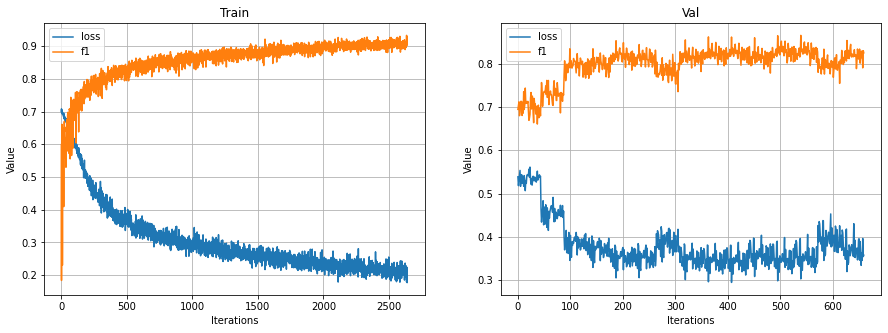

In [ ]:
plot_training(train_loss, train_f1, val_loss, val_f1)

In [59]:
set_seed(42)

epochs = 15

model = WordSymbCNN3(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=epochs,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Epoch 1:
Train loss: 0.8540657548741861, Train metric: 0.571468710899353
Val loss: 0.5925577228719537, Val metric: 0.6072235703468323
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.5019360181282867, Train metric: 0.7588728070259094
Val loss: 0.46064620397307654, Val metric: 0.7462744116783142
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.4071633751419457, Train metric: 0.8061220049858093
Val loss: 0.3894736922600053, Val metric: 0.8106205463409424
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.360296212814071, Train metric: 0.8293666243553162
Val loss: 0.36387448690154334, Val metric: 0.824314296245575
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.332064989446239, Train metric: 0.8438661098480225
Val loss: 0.35028251666914334, Val metric: 0.8283755779266357
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.31213530813428486, Train metric: 0.8536360263824463
Val loss: 0.34273306889967486, Val metric: 0.8

In [60]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


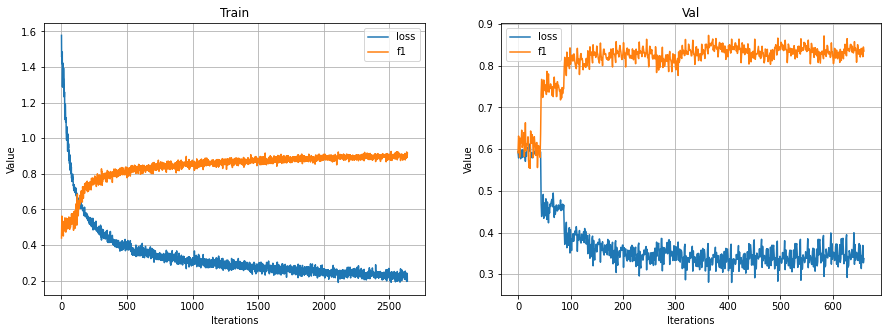

In [61]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Нуууу, немного лучше..

In [63]:
set_seed(42)

epochs = 25

model = WordSymbCNN3(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_loss, val_loss, train_f1, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=epochs,
                                               metric=f1,
                                               scheduler=scheduler)

Training...


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.0726021477444605, Train metric: 0.5179857611656189
Val loss: 0.6699089136990634, Val metric: 0.22866301238536835
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.6886003887788816, Train metric: 0.5973923206329346
Val loss: 0.6036717309193178, Val metric: 0.6151641607284546
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.5589991299943491, Train metric: 0.7273004651069641
Val loss: 0.5367761850357056, Val metric: 0.6820046901702881
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.4886812884360552, Train metric: 0.7680351734161377
Val loss: 0.4942800450054082, Val metric: 0.7095398306846619
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.44394164109094575, Train metric: 0.789268434047699
Val loss: 0.45194199274886737, Val metric: 0.7501998543739319
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.4125776636329564, Train metric: 0.8043562173843384
Val loss: 0.4159900193864649, Val metric: 0.

In [64]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


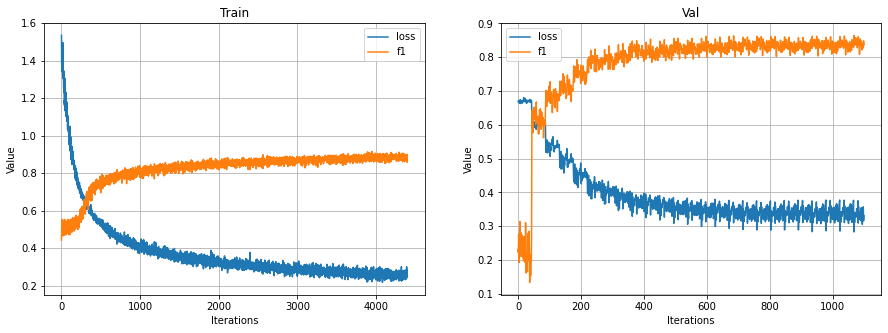

In [65]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Снова на немного улучшили, прелагаю немного читерить

In [80]:
def early_stop_train(train_dataloader, val_dataloader,
                     model, optimizer,
                     criterion, epochs,
                     metric, scheduler=None,
                     device=DEVICE, verbose=False,
                     tol=None):
    
    print('Training...')
    model.train()  
    model.to(device)

    losses = []
    val_losses = []
    f1s = []
    val_f1s = []

    for epoch in tqdm(range(epochs)):

        epoch_loss = [] 
        epoch_metric = []

        if verbose:
            progress_bar = tqdm(total=len(train_dataloader.dataset), desc='Epoch {}'.format(epoch + 1))

        for i, (*x, y) in enumerate(train_dataloader, 1):

            optimizer.zero_grad()

            preds = model(*x)

            loss = criterion(preds, y)

            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            
            batch_metric = metric(preds.round().long(), y.long(), ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())

            if verbose:
                progress_bar.update(y.shape[0])
            
        losses.extend(epoch_loss)
        f1s.extend(epoch_metric)

        print(f'Epoch {epoch+1}:')
        print(f'Train loss: {np.mean(epoch_loss)}, Train metric: {np.mean(epoch_metric)}')
        val_loss, val_metric = evaluate(val_dataloader, model, criterion, metric, device)
        print('* * ' * 10)

        val_losses.extend(val_loss)
        val_f1s.extend(val_metric)
        
        # сделаем остановку, когда добьемся желаемого качества
        if tol is not None:
            if np.mean(val_metric) >= tol:
                return losses, val_losses, f1s, val_f1s

        model.train()
        if scheduler:
            if type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler.step(np.mean(val_loss))
            else:
                scheduler.step()

    return losses, val_losses, f1s, val_f1s


In [81]:
set_seed(42)

epochs = 20

model = WordSymbCNN3(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_loss, val_loss, train_f1, val_f1 = early_stop_train(train_dataloader=train_iterator,
                                                          val_dataloader=val_iterator,
                                                          model=model,
                                                          optimizer=optimizer,
                                                          criterion=criterion,
                                                          epochs=epochs,
                                                          metric=f1,
                                                          scheduler=scheduler, 
                                                          tol=initial_ws_cnn_f1+0.01) # улучим хоть на 1 процент

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 0.8409994833848693, Train metric: 0.5739856958389282
Val loss: 0.588981264016845, Val metric: 0.629025399684906
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 0.5011915437538516, Train metric: 0.7591896057128906
Val loss: 0.4596923284909942, Val metric: 0.7470980286598206
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 0.4066453174772588, Train metric: 0.8064966797828674
Val loss: 0.38939282298088074, Val metric: 0.8104603290557861
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 0.3599573861468922, Train metric: 0.8296014666557312
Val loss: 0.363858662545681, Val metric: 0.8232103586196899
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 0.3319180426611142, Train metric: 0.8441944122314453
Val loss: 0.3503320210359313, Val metric: 0.8284155130386353
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 0.31199378858913074, Train metric: 0.8535630702972412
Val loss: 0.3427210429852659, Val metric: 0.830

In [82]:
print('initial:', initial_ws_cnn_f1)

initial: 0.8305817246437073


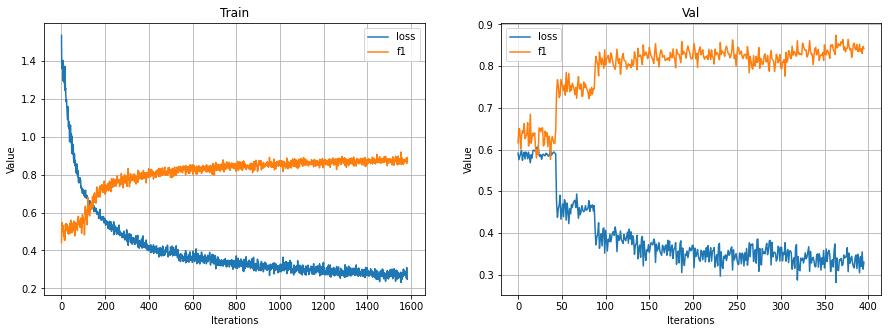

In [83]:
plot_training(train_loss, train_f1, val_loss, val_f1)

Ура! Я надеюсь, такого пока хватит, в целом я думаю, можно еще подкрутить параметры, сделать грид серч и повысить качество, но мой колаб уже не может грузить выводы ячеек. Давайте посмтрим на ошибки модели

# Анализ ошибок

In [84]:
model

WordSymbCNN3(
  (word_embedding): Embedding(116597, 100)
  (f1): Linear(in_features=100, out_features=180, bias=True)
  (symb_embedding): Embedding(175, 10)
  (bigrams): Conv1d(10, 100, kernel_size=(2,), stride=(1,), padding=same)
  (trigrams): Conv1d(10, 80, kernel_size=(3,), stride=(1,), padding=same)
  (pooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (hidden): Linear(in_features=360, out_features=1, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (batch_bi): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_tri): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Sigmoid()
)

In [85]:
set_seed(42)
for (*x, y) in val_iterator:
    break

y = y.long().detach().cpu().numpy().T[0] 
with torch.no_grad():
    preds = model(*x).round().long().detach().cpu().numpy().T[0] 

In [86]:
words = x[0].detach().cpu().numpy()
sents = []
for sent in words:
    sents.append(' '.join([id2word[i] for i in sent if i!=0]))
sents = np.array(sents)

In [87]:
ids = np.where(preds != y)[0]

In [88]:
for id in ids[:10]:
    print('label:', y[id])
    print('pred:', preds[id])
    print(sents[id])
    print()

label: 0
pred: 1
я бы отметить нг под одеяло с мухо на столик рядом оливье икра мясной ассорти шампусик чтоб в обнимка под телевизор эх

label: 1
pred: 0
шымшығать ащы уколда ай жан деген тәтті бір торғать анау мынауғ сынбайтын сауықсын маржан сұлтанб …

label: 0
pred: 1
стоить на свой 48 а ты

label: 0
pred: 1
на регистрация с ноутбук и принтер одна-одинёшенек к такой жизнь я не готовить

label: 0
pred: 1
трудно представить душевный состояние человек за этот год .. молодой россия .. угробить здраво-быть сельск хозяйство экономикаау наука в склиф

label: 0
pred: 1
всеий беесиииттта опять на учёба

label: 1
pred: 0
соңғысын жерлестікк салып қолдайтын сияқтысызть

label: 0
pred: 1
клуб алькатраз хуйня 3 песня говно дабстеп

label: 0
pred: 1
я один казаться что фраза женщина любить ухо и название мужчина ухажёр как то связать друг с друг o_o

label: 0
pred: 1
давыдок ты лысый где твой волос который нравиться я



Видим, что модель ошибается на текстах, где нет никаких явных указаний на тональность. Мне кажется, даже человеку сложно было бы определить их в какой-то класс, все тексты довольно нейтральны в отрыве от контекста твита, так что  такие ошибки модели объяснимы

Еще есть ощущение, что модель переобучается на слова типа `любить`, `нравиться` и тд, и ставим текстам с ними класс 1 


Есть ли какие-то особенности в текстах, крторые модель отличает?

In [89]:
ids = np.where(preds == y)[0]

In [90]:
for id in ids[:10]:
    print('label:', y[id])
    print('pred:', preds[id])
    print(sents[id])
    print()

label: 0
pred: 0
если бы вы я сказать в 2011 год что ваня не попасть на ои то я бы наверное с ум сойти :(

label: 0
pred: 0
блин сейчас идти ксерить документ фотка делать и ещё в нпэк ехать ааа фак

label: 0
pred: 0
ужас какой хотя я быть бы рада если бы я прокесарить бояться так рожать

label: 0
pred: 0
зайти к она на страница и понять что ты быть и правда она дорога .. а я так нагло забрать ты у она ... не любить когда так всё

label: 0
pred: 0
андрей смирнов 15.01 14 яша вернуться я всё прощууа

label: 0
pred: 0
мой суженый так и сделать благо ехать мы по трасса и сирена из фильм быть на флешка жуть :(

label: 1
pred: 1
ебааать на майдан стоять миллион а в россия говорить пара сотня ахах ну около математика #евромайдан

label: 1
pred: 1
ура лето наступить а заней как всегда прислать коморы жара муха пчела

label: 0
pred: 0
всё ещё еда на работа .. пиздец голова не сносить

label: 0
pred: 0
как будто у я там нет музыка зачем он отключить ааа .. я сейчас умереть :(



Ну, да. Видим, что здесь есть особые отличительные черты, характеризующие "положительные" или "отрицательные" тексты: смайлики, слова типа (`ура`, `ужас`, `блин`, `ахах` и тд), так что модель их, конечно, хорошо классифицирует


P.s. можно конечно еще поискать других различий и побольше поанализировать тексты, но мне кажется, что тут уже и так много всего в тетрадке и колаб перестает уже грузить все это, так что я остановлюсь на этом, надеюсь, это норм...